# Building a Traffic sign classifier using TensorFlow with Convolutional neural networks

# Imports

In [113]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np
np.random.seed(101)
%matplotlib inline


# Download Dataset

http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

# Step 0: Load the Data

In [114]:
import pickle
import os

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


In [115]:
 sample_img = X_train[0,:,:,:]
    

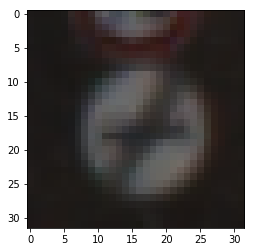

In [116]:
plt.imshow(sample_img)

# Step 1: Dataset Summary & Exploration


In [117]:
print("Number of rows in training dataset is :"+str(len(X_train)))
print("Shape of training dataset is :" +str(X_train.shape))
print("Number of rows in valid dataset is :"+str(len(X_valid)))
print("Shape of valid dataset is :" +str(X_valid.shape))
print("Number of rows in test dataset is :"+str(len(X_test)))
print("Shape of test dataset is :" +str(X_test.shape))

Number of rows in training dataset is :34799
Shape of training dataset is :(34799, 32, 32, 3)
Number of rows in valid dataset is :4410
Shape of valid dataset is :(4410, 32, 32, 3)
Number of rows in test dataset is :12630
Shape of test dataset is :(12630, 32, 32, 3)


# Step 2: Data Preprocessing
Pre-process the Data Set (normalization, grayscale, etc.)
Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, (pixel - 128)/ 128 is a quick way to approximately normalize the data and can be used in this project.

In [118]:
### Preprocess the data here.
import cv2
import numpy as np 

# All the images were also Transform to grayscale, since the accuracy of the model was higher this way (and it shorten the model runtime)
# from shape (32,32,3) to (32,32,1)
def gray_scale(X_input):
    X_output = np.zeros((len(X_input),32,32,1))
    for i in range(len(X_input)):
        img = X_input[i].squeeze()
        img=img.astype(np.uint8)
        X_output[i,:,:,0] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return X_output


In [119]:
# Transform to gray
X_train_gray = gray_scale(X_train)
X_valid_gray = gray_scale(X_valid)
X_test_gray = gray_scale(X_test)

print(X_train_gray.shape)
print(X_valid_gray.shape)
print(X_test_gray.shape)


(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [120]:
# Normalize images to [0,1]
X_train_norm= X_train_gray /255
X_valid_norm= X_valid_gray /255
X_test_norm= X_test_gray /255
# Shuffle 
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train_norm, y_train)
X_test_ready, y_test_ready = shuffle (X_test_norm, y_test)


# Split training and validation
n_train=len(X_train_shuffle)
limRange = int(n_train*0.8)

X_train_ready = (X_train_shuffle[0:limRange+1])
X_valid_ready = (X_train_shuffle[limRange+1:n_train+1])
y_train_ready = y_train_shuffle[0:limRange+1]
y_valid_ready = y_train_shuffle[limRange+1:n_train+1]


# Lenet

![title](lenet1.png)

In [121]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits


# Features and Labels
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [122]:
n_classes=43
#len(np.unique(y_train))

In [123]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

print('done')

done


# Train, Validate and Test the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.


In [126]:
rate = 0.0009

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 28, 28, 6)


# Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [127]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

BATCH_SIZE = 100

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [128]:
from sklearn.utils import shuffle

In [145]:
from time import time
start_time = time()

EPOCHS = 20

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_ready)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_shuff, y_shuff = shuffle(X_train_ready, y_train_ready)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_shuff[offset:end], y_shuff[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid_ready, y_valid_ready)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    saver.save(sess,  "./lenet")
    print("Model saved")    
    print("Final Validation Accuracy = {:.3f}".format(validation_accuracy))



Training...

EPOCH 1 ...
Validation Accuracy = 0.563
EPOCH 2 ...
Validation Accuracy = 0.803
EPOCH 3 ...
Validation Accuracy = 0.884
EPOCH 4 ...
Validation Accuracy = 0.913
EPOCH 5 ...
Validation Accuracy = 0.925
EPOCH 6 ...
Validation Accuracy = 0.934
EPOCH 7 ...
Validation Accuracy = 0.946
EPOCH 8 ...
Validation Accuracy = 0.951
EPOCH 9 ...
Validation Accuracy = 0.958
EPOCH 10 ...
Validation Accuracy = 0.966
EPOCH 11 ...
Validation Accuracy = 0.964
EPOCH 12 ...
Validation Accuracy = 0.969
EPOCH 13 ...
Validation Accuracy = 0.973
EPOCH 14 ...
Validation Accuracy = 0.973
EPOCH 15 ...
Validation Accuracy = 0.975
EPOCH 16 ...
Validation Accuracy = 0.978
EPOCH 17 ...
Validation Accuracy = 0.975
EPOCH 18 ...
Validation Accuracy = 0.980
EPOCH 19 ...
Validation Accuracy = 0.981
EPOCH 20 ...
Validation Accuracy = 0.981
Model saved
Final Validation Accuracy = 0.981


#  Custom Model Architecture Lenet 2

![title](model.jpg)

In [134]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet2(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    
    
    W2 = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 12), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='SAME')
    b2 = tf.Variable(tf.zeros(12))
    x = tf.nn.bias_add(x, b2)
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    
    
    # TODO: Layer 3: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

In [135]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, 43)

print('done')

done


In [136]:
rate = 0.0009

logits = LeNet2(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 28, 28, 6)


In [137]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

BATCH_SIZE = 100

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [138]:
from time import time
start_time = time()

EPOCHS = 20

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_ready)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_shuff, y_shuff = shuffle(X_train_ready, y_train_ready)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_shuff[offset:end], y_shuff[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 0.5})

        validation_accuracy = evaluate(X_valid_ready, y_valid_ready)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))


Training...

EPOCH 1 ...
Validation Accuracy = 0.543
EPOCH 2 ...
Validation Accuracy = 0.839
EPOCH 3 ...
Validation Accuracy = 0.906
EPOCH 4 ...
Validation Accuracy = 0.925
EPOCH 5 ...
Validation Accuracy = 0.939
EPOCH 6 ...
Validation Accuracy = 0.955
EPOCH 7 ...
Validation Accuracy = 0.954
EPOCH 8 ...
Validation Accuracy = 0.963
EPOCH 9 ...
Validation Accuracy = 0.967
EPOCH 10 ...
Validation Accuracy = 0.970
EPOCH 11 ...
Validation Accuracy = 0.975
EPOCH 12 ...
Validation Accuracy = 0.977
EPOCH 13 ...
Validation Accuracy = 0.979
EPOCH 14 ...
Validation Accuracy = 0.979
EPOCH 15 ...
Validation Accuracy = 0.981
EPOCH 16 ...
Validation Accuracy = 0.978
EPOCH 17 ...
Validation Accuracy = 0.982
EPOCH 18 ...
Validation Accuracy = 0.981
EPOCH 19 ...
Validation Accuracy = 0.984
EPOCH 20 ...
Validation Accuracy = 0.985


# Evaluate on Test Set

In [146]:
# Now (drumroll) evaluate the accuracy of the model on the test dataset

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('lenet.meta')
    saver2.restore(sess, "lenet")
    test_accuracy = evaluate(X_test_ready, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))


INFO:tensorflow:Restoring parameters from lenet
Test Set Accuracy = 0.039


# Log


2018/07/16 - 95.9%
preprocessing: grayscale, normalization
model: original LeNet, batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1


2016/01/04 - 98.5%
model: modified LeNet
additional convolution layer (no max pool) flattened and concatenated with flattened layer 2 output
i.e. 5x5x16 branched off to 5x5 convolution (output of 1x1x400), each flattened (to 400) and concatenated (800)
all other layers the same, except first fully connected to accommodate change from 400 to 800
all other hyperparameters and preprocessing the same
2016/01/04 - 98.3%
model: further modified LeNet
removed last two fully connected layers so that the lone fully connected layer acts as classifier (800 -> 43)
all other hyperparameters and preprocessing the same
2016/01/04 - 97.5%
reduced learning rate 50% (to 0.0005) after observing some bounce in accuracy across epochs
2016/01/05 - 98.6%
changed learning rate to 0.0008, nothing more
2016/01/08 - after a few days of implementing data augmentation (and one day off in there) I'm having trouble improving or even getting close to my previous validation accuracy. I first tried augmenting all labels up to the point of 1500 samples (which takes a very long time, even on GPU - now working), but it seems to have crippled my validation accuracy to ~70% (where-about it starts and ends across all epochs). Obviously I'm doing something wrong in my data augmentation, so that's where I am right now.
2016/01/08 - squashed the bug in the augmentation code and got accuracy back to high 90's, then implemented dropout and (after some difficulty) achieved similar accuracy (~97%)
2016/01/08 - 98.3%
after the changes above, adjusted the keep_prob from 0.5 to 0.75
still LeNet2, batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1
2016/01/08 - 92.8%
model: LeNet2, batch size: 256, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.3
2016/01/08 - 98.2%
model: LeNet2, batch size: 256, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.1
2016/01/08 - 97.7%
model: LeNet2, batch size: 256, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.05
2016/01/08 - 93.4%
model: LeNet2, batch size: 512, epochs: 15, rate: 0.00075, mu: 0, sigma: 0.1
2016/01/08 - 95.3%
model: LeNet2, batch size: 512, epochs: 25, rate: 0.00075, mu: 0, sigma: 0.1
2016/01/08 - 97.7%
model: LeNet2, batch size: 64, epochs: 25, rate: 0.00075, mu: 0, sigma: 0.1
2016/01/08 - 97.9%
model: LeNet2, batch size: 64, epochs: 25, rate: 0.001, mu: 0, sigma: 0.1
2016/01/08 - 98.2%
model: LeNet2, batch size: 100, epochs: 25, rate: 0.001, mu: 0, sigma: 0.1
2016/01/08 - 98.5%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.001, mu: 0, sigma: 0.1
leveled off around epoch 50
2016/01/08 - 98.8%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1
2016/01/08 - 98.7%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0008, mu: 0, sigma: 0.1
2016/01/08 - 98.7%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0005, mu: 0, sigma: 0.1
2016/01/08 - 97.7%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0001, mu: 0, sigma: 0.1
2016/01/08 - 99.0%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.6
2016/01/08 - 99.0%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.55
2016/01/08 - 99.0%
model: LeNet2, batch size: 100, epochs: 100, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5
2016/01/08 - 98.9%
model: LeNet2, batch size: 100, epochs: 60, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5
2016/01/08 - 99.1%
model: LeNet2, batch size: 100, epochs: 60, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5
2016/01/16 - 99.3%
model: LeNet2, batch size: 100, epochs: 60, rate: 0.0009, mu: 0, sigma: 0.1, keep_prob: 0.5